In [1]:
import baltic as bt
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import HTML
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch


def colourDict(data,cmap=mpl.cm.viridis):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name
    """
    cmap=cmap # default viridis
    data_unique=sorted(list(set(data))) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

def legend(dictionary,marker='o',markersize=15,labelspacing=1,fontsize=10,ax='',style='italic',loc='best',bbox_to_anchor=(0.5, 0.5),fontname='Arial'): # `'upper left', 'upper right', 'lower left', 'lower right'
    """ Returns a legend object from a dictionary"""
    legend_elements=[]
    for key,value in dictionary.items():
        legend_elements.append(Line2D([0],[0],marker=marker,color=value,label=key,markersize=markersize))
    leg=ax.legend(handles=legend_elements, loc=loc,labelspacing=labelspacing,prop={'size': fontsize,'style':style,'family':fontname},bbox_to_anchor=bbox_to_anchor)
    return leg

#### header of the asc raster file

**ncols**        756  
**nrows**        986  
**xllcorner**    119.673045041181  
**yllcorner**    -51.758267701856  
**dx**           0.083337772080  
**dy**           0.083346645537  
**NODATA_value**  3.4028234663852885981e+38  

In [2]:
# the raster was created in QGIS
# 90m SRTM files were downloaded from https://srtm.csi.cgiar.org/ on March 22, 2021
# the rasters where merged using "raster > merge" in QGIS and with a 20 fold lower resolution (due to file size and processing time)
# the raster was converted into an asc format using raster > misclenaeous > convert

# loading the raster
raster=pd.read_csv('./map/merged_clip.asc',skiprows=7,sep=' ',header=None,dtype='float')
# masks the cells with nule data using the value asigned by qgis as nule data
rasterplot=raster.mask(np.isclose(raster.values,3.4028234663852885981e+38,rtol=0.00001))
# replacing sea cells with np.nan
rasterplot.replace(0,np.nan,inplace=True)
# raster information.. you can find it in the first 7 lines of the asc file
nrows=756;ncols=986
cellsize=0.083346645537

# gets the left-bottom corners and calculates the right top ones using the number of rows/columns and the cellsize
# that will be used to transform the coordinates into axis-plot coordinates
xmin=119.673045041181;xmax=119.673045041181+(ncols*cellsize)
ymin=-51.758267701856;ymax=-51.758267701856+(nrows*cellsize)

# cellsize of the raster
# just checking that things add up
xcell=((xmin-xmax)/ncols)*-1
ycell=(ymax-ymin)/nrows
print(xcell,ycell)
print(ymin,ymax)
print(ymax-ymin)

0.083346645537 0.083346645537
-51.758267701856 11.251796324116
63.010064025972


In [5]:
# loads all the data files
# tuna metadata
tuna_data=pd.read_csv('./tuna_sample_metadata.csv',sep='\t')
# diet information
fish_diet=pd.read_csv('./Mifish_species_list_with_sample_counts.csv',sep=',')
molusk_diet=pd.read_csv('./Ceph_species_list_with_sample_counts.csv',sep=',')
crus_diet=pd.read_csv('./Crust_species_list_with_sample_counts.csv',sep=',')

# loading coordinates
# coords_old=pd.read_csv('./coordinates.csv', sep=',')  # old coordinates
coords = pd.read_csv('./Camberra_list_Diane_Jonas_20210422.txt', sep = '\t')
# transform the coordinates to have the same system as the raster (based on the rows and columns indices)
coords['longs']=(coords['longitude_dec']-xmin)//cellsize
coords['lats']=((-coords['latitude_dec']-ymin)//cellsize)-260 # transformation to deal with coordinates below and above the ecuador
ecuador=(0-ymin//cellsize)-260 # to check!

[-51.    -40.875 -30.75  -20.625 -10.5    -0.375   9.75   19.875  30.   ]


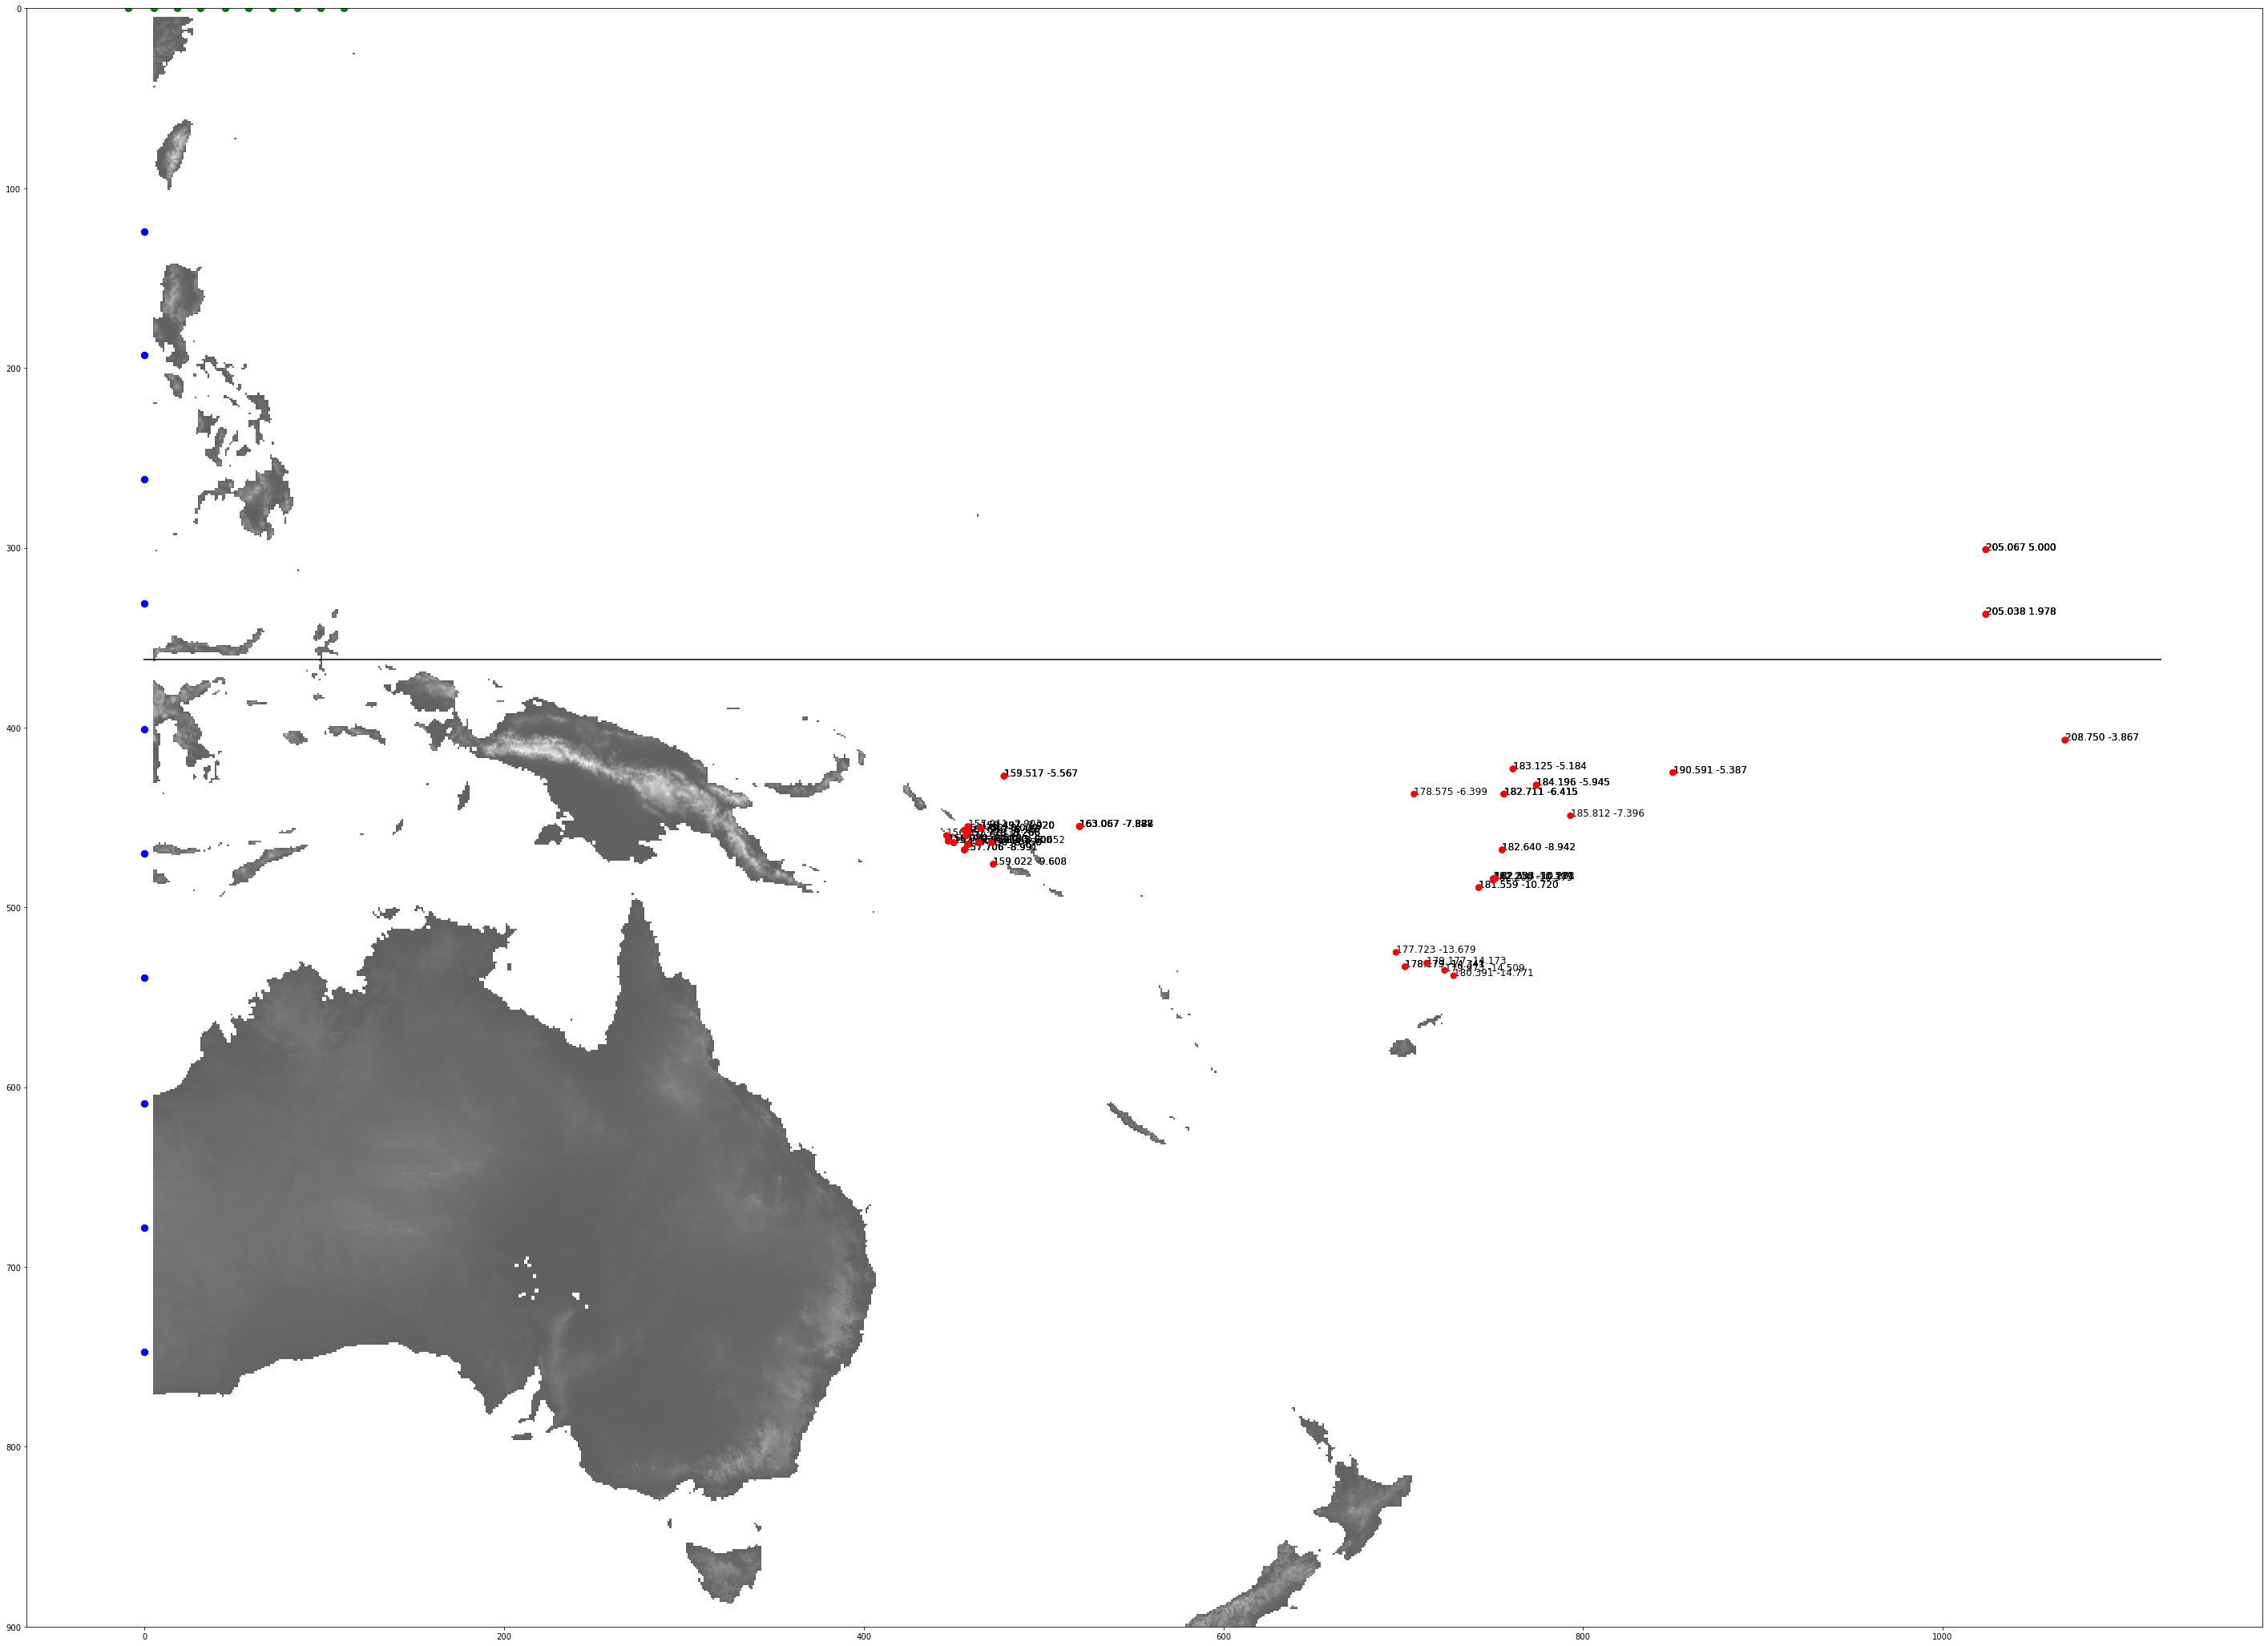

In [6]:
# quickly checking how the raster looks like and if the data is correct
fig,ax = plt.subplots(figsize = (50,100))

# asigns a list of tuples to create a colormap. Assigns one colour to each value. More than two are possible if desired.
clist=[(0.0,'#616161'),
       (1.0,'#ffffff')]
# creates the colourmap based on the list above and gives it a name
cmap=mpl.colors.LinearSegmentedColormap.from_list('mapcmap',clist)
# plots the raster using the colourmap above. Normalizes by altitude in the raster
ax.imshow(rasterplot, cmap = cmap, norm = mpl.colors.Normalize(vmin=0, vmax=rasterplot.max().max()))
# plotting the transformed coordinates
ax.scatter(coords['longs'],coords['lats'],s=70,zorder=4,facecolor='r',alpha=1,edgecolor='none') # background
ax.hlines(ecuador, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1])
for row in coords.itertuples():
    # plots the coordinates before transformation to make sure the transformation didn't mess things up
    ax.text(row.longs, row.lats, '%.3f %.3f'%(row.longitude_dec,row.latitude_dec), fontsize = 12)
ax.scatter([0]*len(yyticksplot),yyticksplot,s=70,color='b')
ax.scatter(xxticksplot,[0]*len(xxticksplot),s=70,color='g')
# sets limits
# ax.set_xlim(0,710)
ax.set_ylim(900,0)
print(np.linspace(-51,30,9))
plt.show()

In [7]:
# unique species in the data
coords['scientific_name'].unique()

array(['Thunnus albacares', 'Katsuwonus pelamis'], dtype=object)

In [8]:
tuna_data['scientific_name'].unique()

array(['Thunnus albacares', 'Katsuwonus pelamis'], dtype=object)

In [9]:
# fish sample_ID is missing from the "camberra_list" of coordinates, but we can conenct it via the "sample_number"
coords.columns
print('Sample number in coords file\n',coords['Sample number'].head(5))
print('Sample number and sample ID in tuna_metadata\n',tuna_data[['Sample number','sample ID']].head(5))

# make dictionary using tuna_metadata
# we do it because columns in diet files can be connected to tuna via the sample ID only
number_id_dict = dict(zip(tuna_data['Sample number'],tuna_data['sample ID']))

# add a column in coords with the sample ID
coords['index'] = coords['Sample number'].map(number_id_dict)
coords.head(5)

Sample number in coords file
 0     CP11TAGCP11-02/P340
1     CP11TAGCP11-02/P320
2     CP11TAGCP11-02/P341
3     CP11TAGCP11-02/P614
4    CP11TAGCP11-02/B2503
Name: Sample number, dtype: object
Sample number and sample ID in tuna_metadata
           Sample number        sample ID
0  CP11TAGCP11-02/B2503  GMB.20190206-28
1  CP11TAGCP11-02/B2538  GMB.20190206-26
2  CP11TAGCP11-02/B2539  GMB.20190206-27
3   CP11TAGCP11-02/P320  GMB.20190206-19
4   CP11TAGCP11-02/P340  GMB.20190206-25


,Sample number,fish_id,fish_no,trip_name,trip_no,set_no,latitude,longitude,latitude_dec,longitude_dec,scientific_name,longs,lats,index
0,CP11TAGCP11-02/P340,131398,P340,CP11TAG,CP11-02,10,0352.000S,15115.000W,-3.866667,208.750000,Thunnus albacares,1068.0,407.0,GMB.20190206-25
1,CP11TAGCP11-02/P320,131366,P320,CP11TAG,CP11-02,1,0158.700N,15457.700W,1.978333,205.038333,Katsuwonus pelamis,1024.0,337.0,GMB.20190206-19
2,CP11TAGCP11-02/P341,131399,P341,CP11TAG,CP11-02,10,0352.000S,15115.000W,-3.866667,208.750000,Katsuwonus pelamis,1068.0,407.0,GMB.20190206-21
3,CP11TAGCP11-02/P614,131432,P614,CP11TAG,CP11-02,19,0500.000N,15456.000W,5.000000,205.066667,Katsuwonus pelamis,1024.0,301.0,GMB.20190206-20
4,CP11TAGCP11-02/B2503,131363,B2503,CP11TAG,CP11-02,1,0158.700N,15457.700W,1.978333,205.038333,Thunnus albacares,1024.0,337.0,GMB.20190206-28


In [10]:
# how many of the coordinates in coords file can be connected to tuna metadata and diet data?
print(coords['index'].isna().describe())

# checking if the sample ids are present in both files or if something cannot be connected across files
incoords = {x for x in coords['index']}
intuna = {x for x in tuna_data['sample ID']}
# items in setA that are not shared with setB and viceversa
# symmetric difference 
print(incoords ^ intuna) # niceee, nothing is missing

count        96
unique        1
top       False
freq         96
Name: index, dtype: object
set()


In [12]:
# checking which IDs (tuna samples) are where and what is missing
checkingid = {'coords': pd.Series(coords['index'].values), 'tunalist': pd.Series(tuna_data['sample ID'].values),
             'fishids': pd.Series([x for x in fish_diet.columns if x not in ['OTU','Classification']]), 'moluskids': pd.Series([x for x in molusk_diet.columns if x not in ['OTU','Classification']]),
             'custids': pd.Series([x for x in crus_diet.columns if x not in ['OTU','Classification']])}

idsdf = pd.DataFrame(checkingid)
idsdf.isna().describe()

,coords,tunalist,fishids,moluskids,custids
count,96,96,96,96,96
unique,1,1,2,2,2
top,False,False,False,False,False
freq,96,96,93,50,66


In [13]:
# just checking the columns on the tuna dataset
coords.columns

Index(['Sample number', 'fish_id', 'fish_no', 'trip_name', 'trip_no', 'set_no',
       'latitude', 'longitude', 'latitude_dec', 'longitude_dec',
       'scientific_name', 'longs', 'lats', 'index'],
      dtype='object')

In [15]:
# concatenating all diet datasets to sum up number of otus per tuna and make sorted list
pd.set_option('display.max_rows', None)
alldiets = pd.concat([fish_diet,molusk_diet,crus_diet], sort = False, ignore_index = True)
alldiets.drop(columns = ['OTU','Classification'],inplace = True)
sortedtuna = alldiets.sum().sort_values(ascending = False).index # dont use max, use sums

In [16]:
from collections import OrderedDict

# creates two empty dictionaries to store the diet OTUs for each tuna
# tuna_diet={}
tuna_diet=OrderedDict()
# we will remove anything with less than 100 reads
# tuna_diet_filtered={}
tuna_diet_filtered=OrderedDict()
# iterates through the tuna ID in the ID column of the tuna file
# for tid in tuna_data['sample ID']: # using the tuna ids in the metadata file
for tid in sortedtuna: #coords['index']: # using the tuna ids in the coordinate files
    # creates two empty dictionaries to store OTU (keys) and number of reads for each OTU (values)
    diet_otus={}
    diet_otus_filt={}
    # iterate through the tree data files of diets
    for index,diet in enumerate([fish_diet,molusk_diet,crus_diet]):
        # tuna ID are stored as columns in the diet datasets
        if tid in diet.columns:
            # adds a key depending on the dataset opened at each loop, using a list of names (sorted as the list of datasets) and the index to slice it
            diet_otus[['fish','molusk','crus'][index]]=list(diet[tid].values)
            # same as above, but filters out anything lower than 100
            diet_otus_filt[['fish','molusk','crus'][index]]=[x for x in diet[tid].values if x>= 100] # you can play around with the integer here to prove that the figure below works :)
    # asigns diet dictionaries to each tuna key
    tuna_diet[tid]=diet_otus
    tuna_diet_filtered[tid]=diet_otus_filt

In [17]:
# removing the sample with almost no reads
tuna_diet.pop('GMB.20190207-E', None)
tuna_diet_filtered.pop('GMB.20190207-E', None)

{'fish': [216], 'crus': []}

In [18]:
print('numero de muestras con sample number en metadata: ',len(tuna_data['Sample number']))
print('number of unique sample IDs from the diet files: ',len(tuna_diet_filtered.keys()))

numero de muestras con sample number en metadata:  96
number of unique sample IDs from the diet files:  92


In [19]:
# also, using sample number instead of sample ID
tuna_data.columns
tuna_data['Sample number']
# dictionary connecting sample ID to sample number
tuna_labels_dict = dict(zip(tuna_data['sample ID'],tuna_data['Sample number']))
tuna_labels_dict['none'] = 'none'

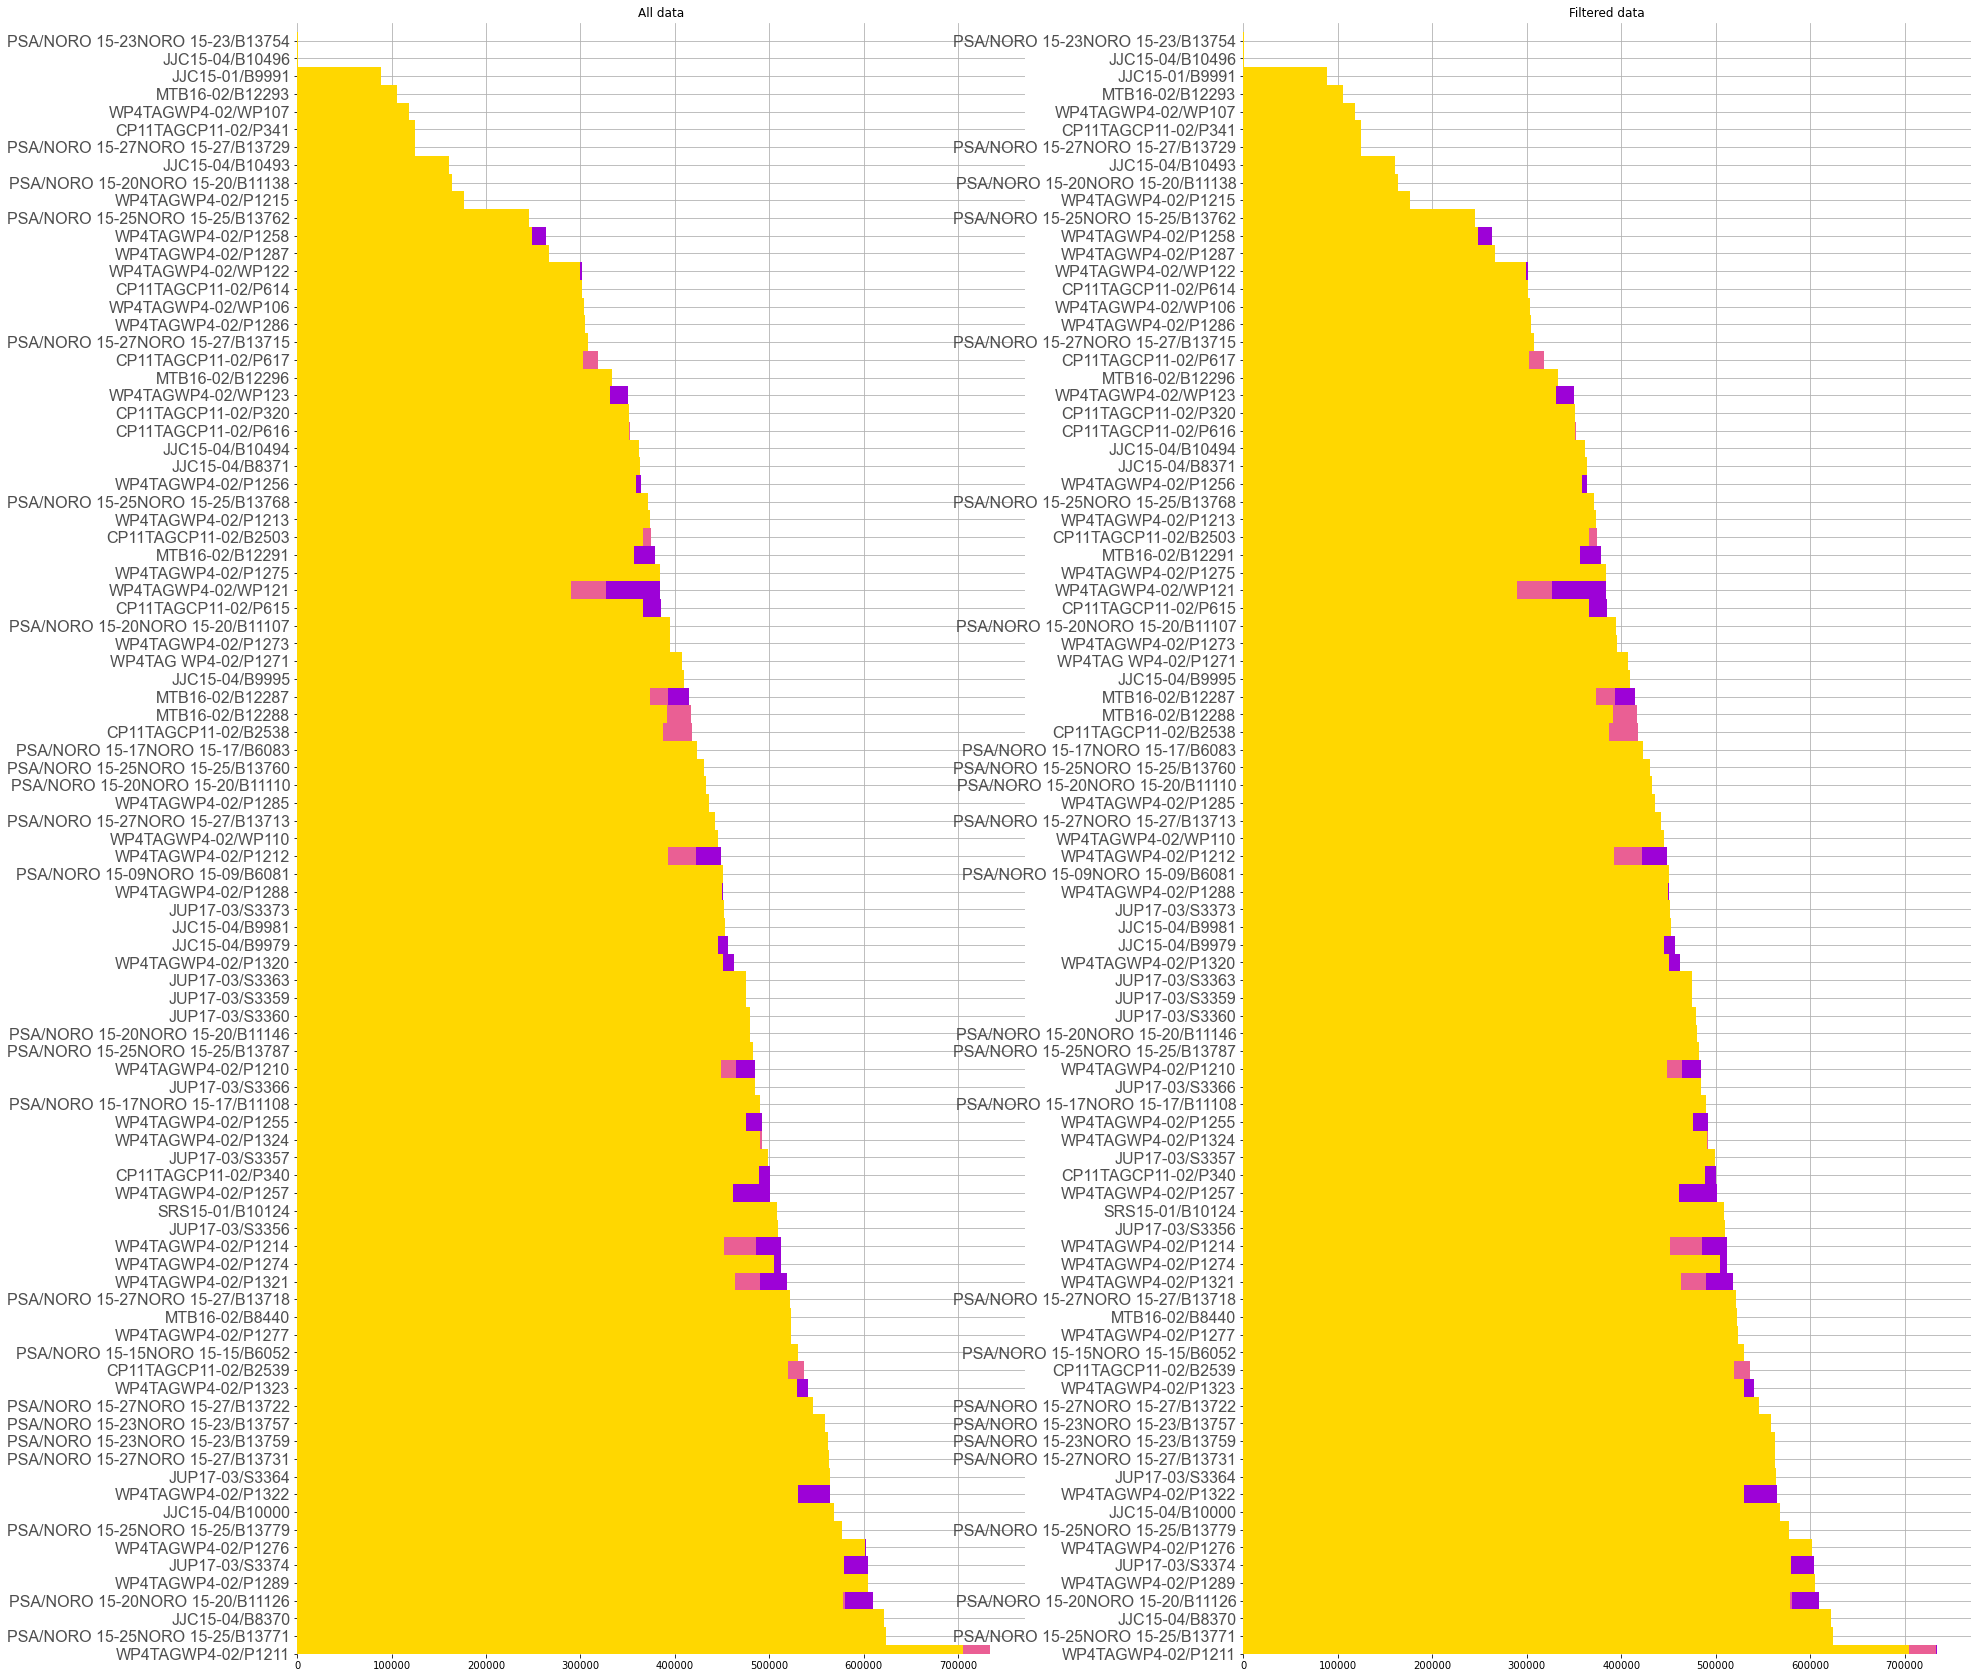

In [20]:
diet_col={'fish':'#FFD700','molusk':'#EA5F94','crus':'#9D02D7'}

fig = plt.figure(figsize=(30,30),facecolor='w') 
G = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.0)

# create labels with sample number

# iterate trough the dictionaries with Sample ID and diet (with three values)
for index,data in enumerate([tuna_diet, tuna_diet_filtered]):
    # names to use as labels from the sample collection code
    labels = ['%s'%(tuna_labels_dict[key] if key in tuna_labels_dict else 'none') for key in data.keys()]
    # assigns axis to each plot to compare filtered and unfiltered OTUs
    ax=plt.subplot(G[0,index],facecolor='none')  
    yticks=[]
    # iterates trough the tuna ID and its diet types
    for ypos,(tid,diet) in enumerate(data.items()):
        left=0
        yticks.append(ypos)
        # iterates through diet types and number of reads per OTU
        for kind in diet.keys():
#             width=sum(diet[kind])
            width=sum(diet[kind])
#             print(kind,sum(diet[kind]),diet[kind])
            height=1
            ax.barh(ypos,width,height,left=left,align='center',facecolor=diet_col[kind],zorder=2)
            left+=width
        ax.set_ylim(0,len(data.keys()))
        [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
        plt.grid(axis='both',zorder=1)
    plt.yticks(ticks=yticks,labels = labels,fontsize=16,fontname='Arial',color='#4f4f4f')
    plt.title('All data' if index == 0 else 'Filtered data')
plt.show()

### this plot works.. it just happens that the filtered data is almost the same as the whole data, only minus de zeros!!!

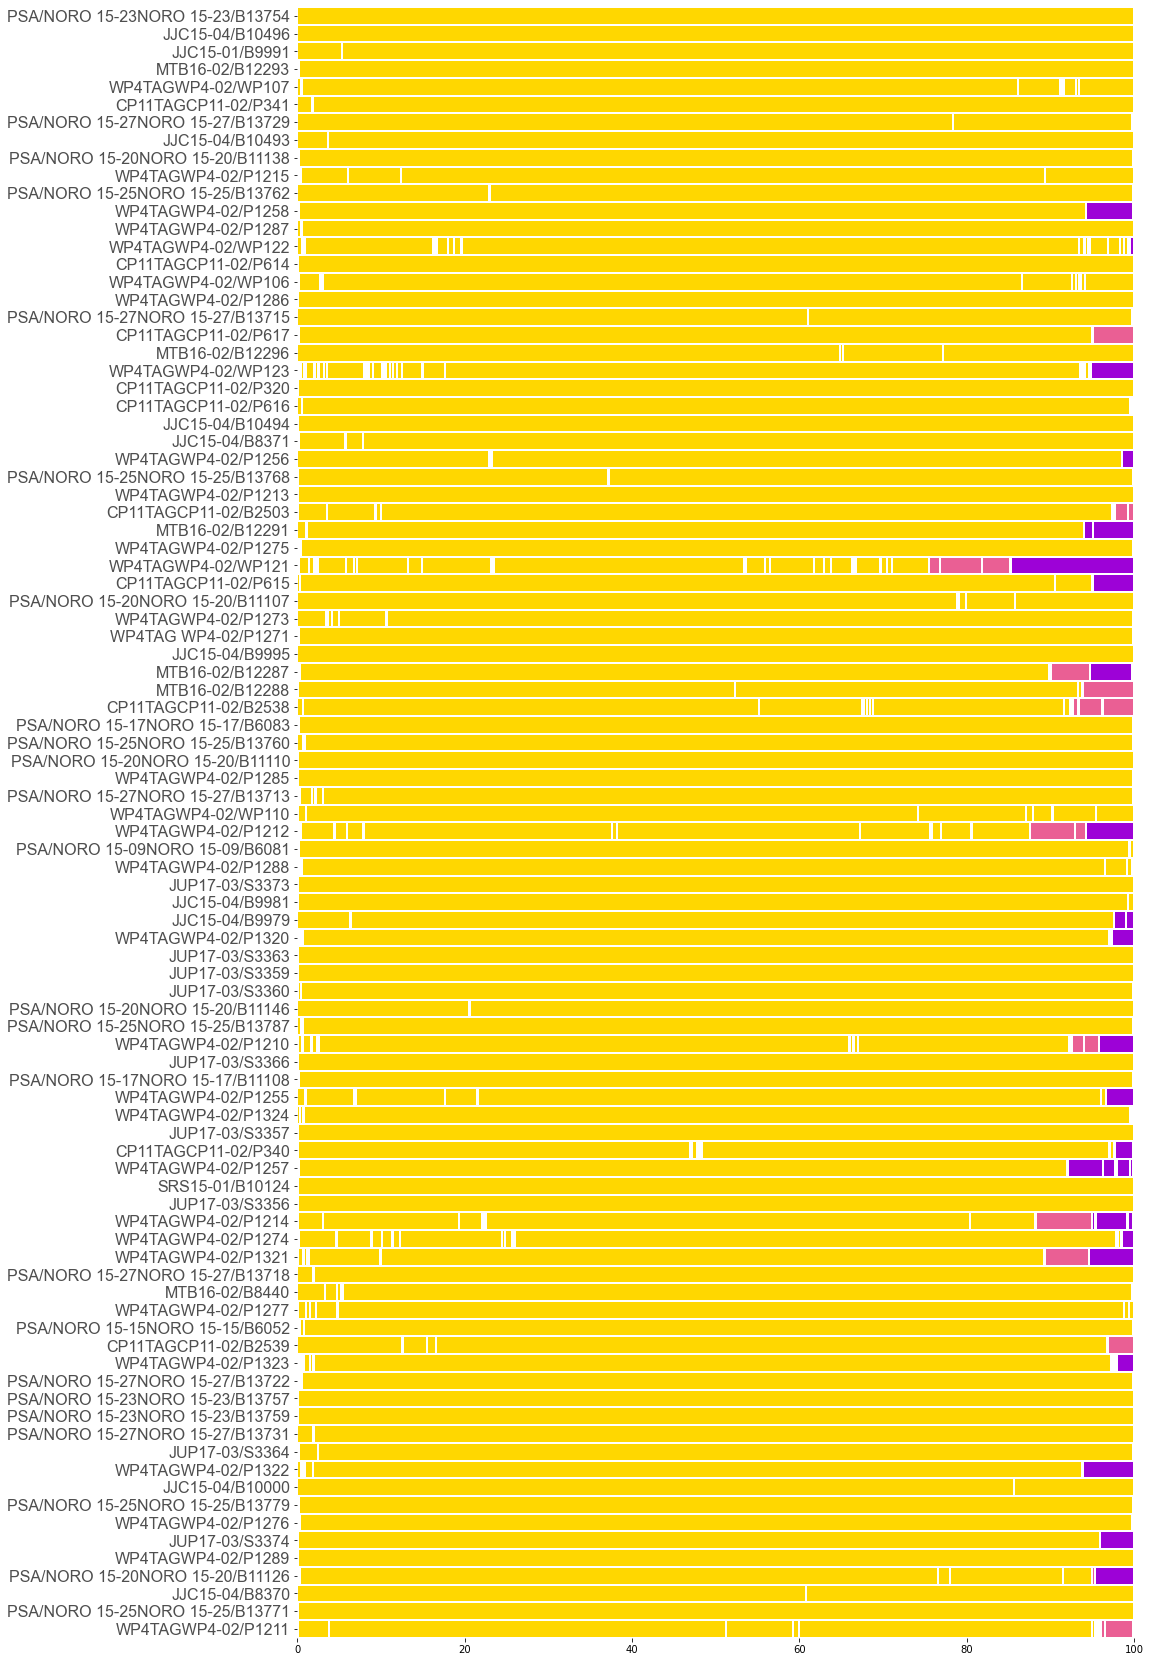

In [21]:
# quickly checking how using percentages rather than raw numbers 
fig,ax=plt.subplots(figsize=(15,30),facecolor='none')
ax.set_xlim(0,100)
ax.set_ylim(0,len(tuna_diet_filtered.items()))

diet_col={'fish':'#FFD700','molusk':'#EA5F94','crus':'#9D02D7'}
# grey lines on the back
# for x in np.arange(0,2e6,200):
#     ax.axvspan(xmin=x,xmax=x+(200/2),ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],facecolor="#bababa",alpha=0.1,zorder=1)    

# create labels with sample number

yticks=[]
for ypos,(tid,diet) in enumerate(tuna_diet_filtered.items()):
    labels = ['%s'%(tuna_labels_dict[key] if key in tuna_labels_dict else 'none') for key in data.keys()]
    left=0
    yticks.append(ypos+0.5)
    total=sum(sum([x for x in tuna_diet_filtered[tid].values()],[]))
    if total > 0:
        for kind in diet.keys():
            for otu in diet[kind]:
                width=(otu*100)/total
                height=1
                ax.barh(ypos,width,height,left=left,align='edge',facecolor=diet_col[kind],edgecolor='w',lw=2)
                left+=width
# plt.grid(axis='both',zorder=1)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.yticks(ticks=yticks,labels = labels,fontsize=16,fontname='Arial',color='#4f4f4f')

plt.show()

In [22]:
# color maps!!!! this example shows different colours for even and odd OTUs
fishclist=[(0.0,'#f7ecb2'),(1.0,'#FFD700')]
moluskclist=[(0.0,'#fac8db'),(1.0,'#EA5F94')]
crusclist=[(0.0,'#e5a1ff'),(1.0,'#9D02D7')]
fishcmap=mpl.colors.LinearSegmentedColormap.from_list('fishmap',fishclist)
moluskcmap=mpl.colors.LinearSegmentedColormap.from_list('moluskmap',moluskclist)
crusmap=mpl.colors.LinearSegmentedColormap.from_list('crusmap',crusclist)

colormap_list=[fishcmap,moluskcmap,crusmap]

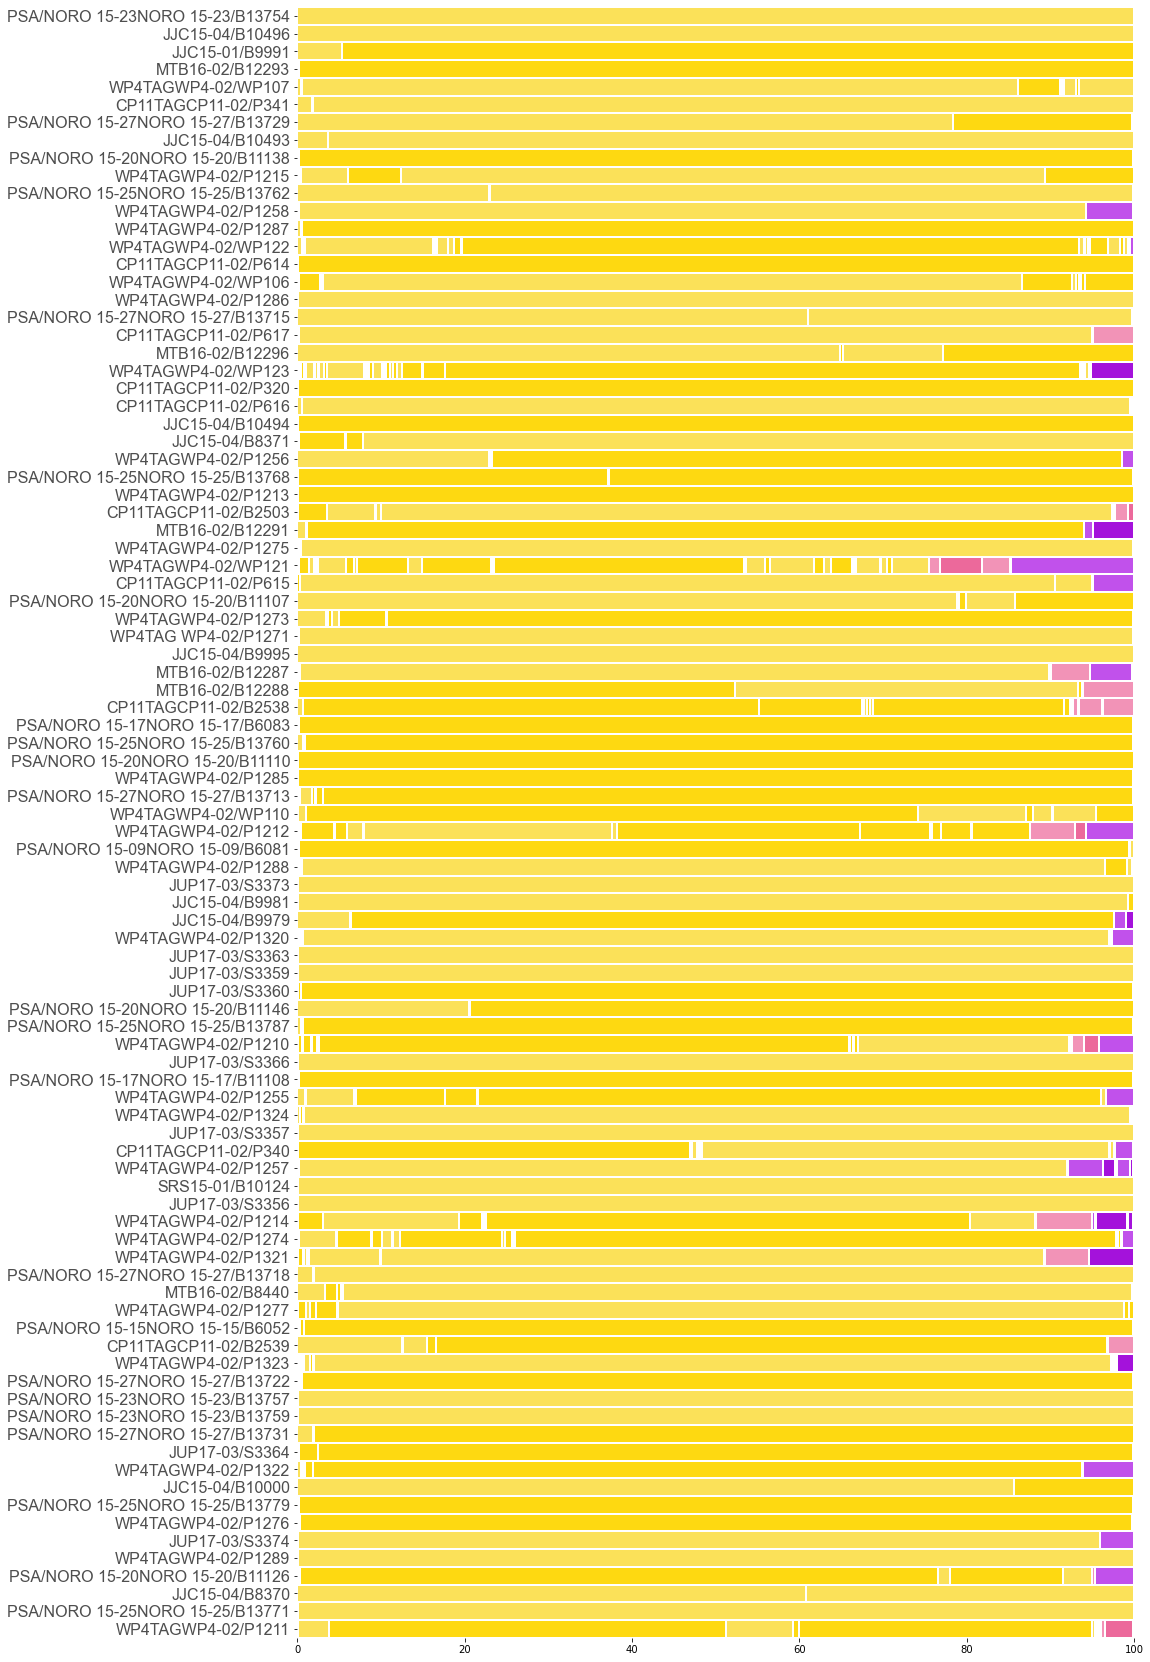

In [23]:
fig,ax=plt.subplots(figsize=(15,30),facecolor='none')
ax.set_xlim(0,100)
ax.set_ylim(0,len(tuna_diet_filtered.items()))

diet_col={'fish':fishcmap,'molusk':moluskcmap,'crus':crusmap}
# grey lines on the back
# for x in np.arange(0,2e6,200):
#     ax.axvspan(xmin=x,xmax=x+(200/2),ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],facecolor="#bababa",alpha=0.1,zorder=1)    

# create labels with sample number
labels = ['%s'%(tuna_labels_dict[key] if key in tuna_labels_dict else 'none') for key in data.keys()]

yticks=[]
for ypos,(tid,diet) in enumerate(tuna_diet_filtered.items()):
    left=0
    yticks.append(ypos+0.5)
    total=sum(sum([x for x in tuna_diet_filtered[tid].values()],[]))
    if total > 0:
        for kind in diet.keys():
            for i,otu in enumerate(diet[kind]):
                width=(otu*100)/total
                height=1
#                 ax.barh(ypos,width,height,left=left,align='edge',facecolor=diet_col[kind](0.4 if (i%2)==0 else 0.7),edgecolor='w',lw=0.5)
                if (i%2)==0:
                    colnum=0.5 # 0.3
#                 elif (i%2)==0:
#                     colnum=0.7
                else:
                    colnum=0.9
                ax.barh(ypos,width,height,left=left,align='edge',facecolor=diet_col[kind](colnum),edgecolor='w',lw=2) # grey '#cacaca'
                left+=width

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.yticks(ticks=yticks,labels = labels,fontsize=16,fontname='Arial',color='#4f4f4f')

plt.show()

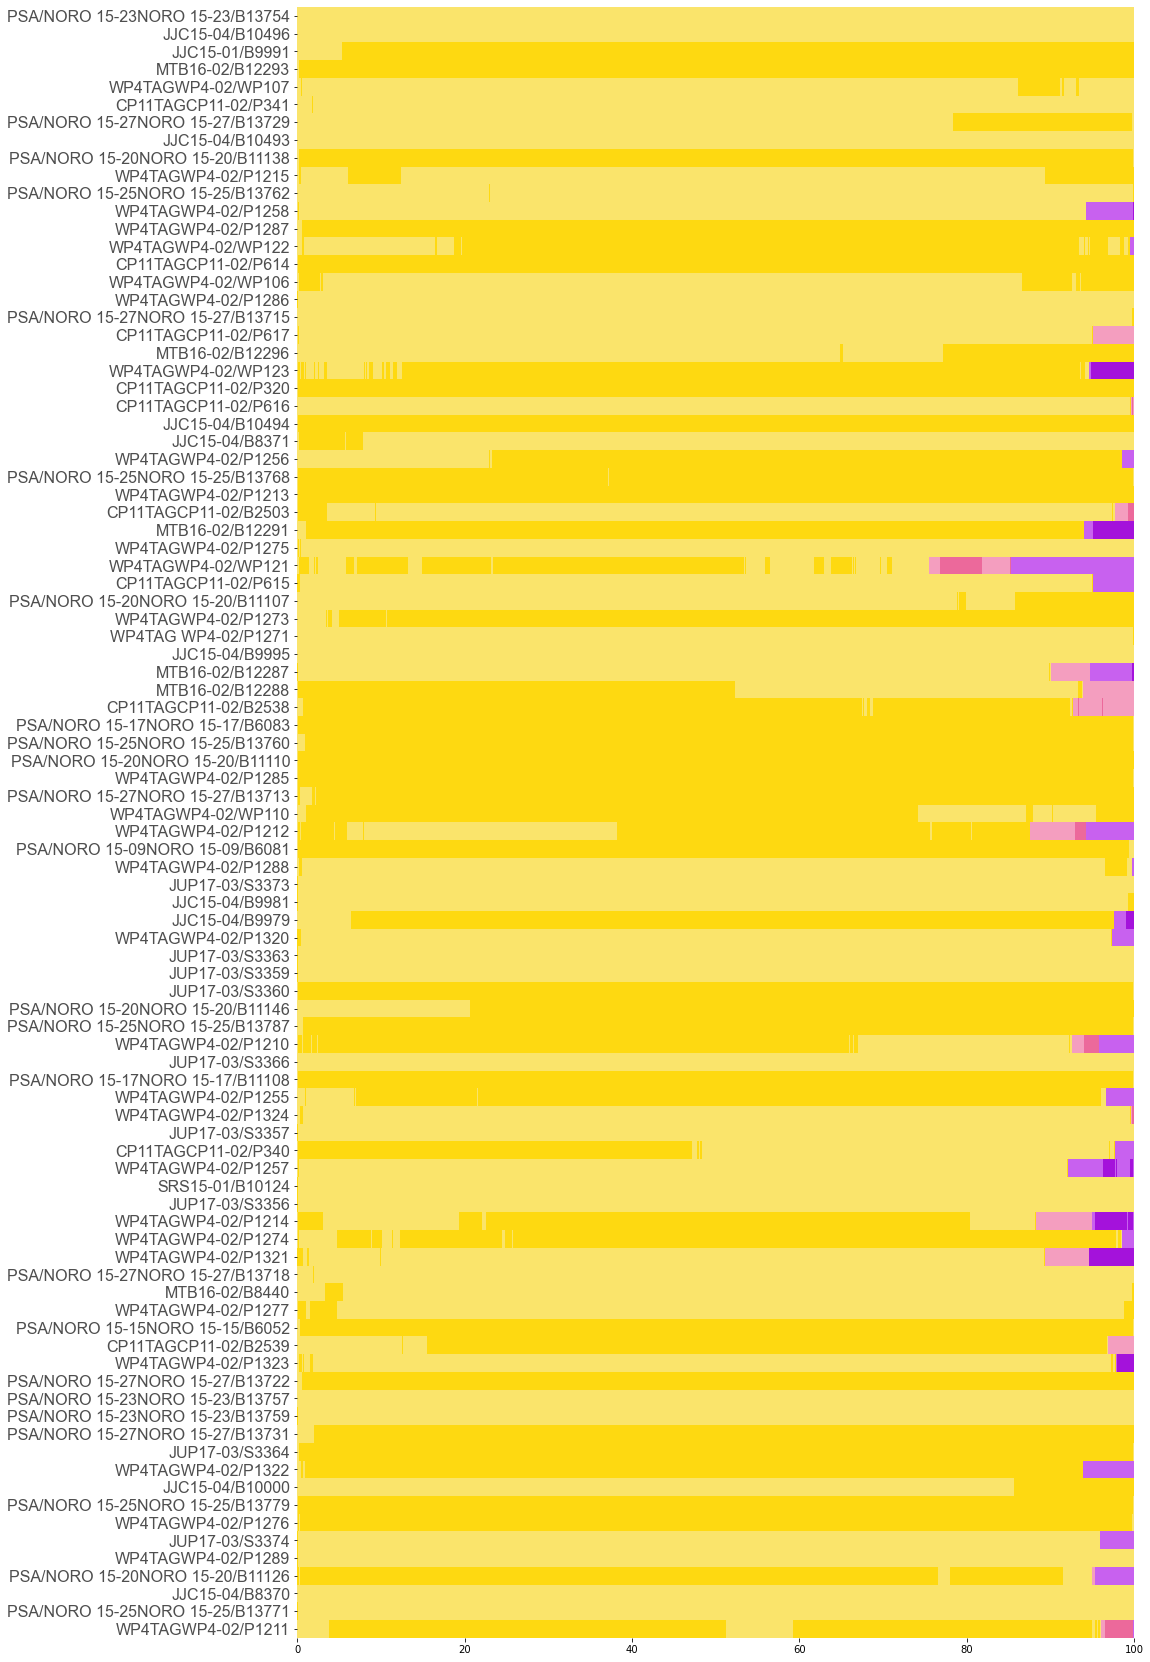

In [24]:
fig,ax=plt.subplots(figsize=(15,30),facecolor='none')
ax.set_xlim(0,100)
ax.set_ylim(0,len(tuna_diet.items()))

diet_col={'fish':fishcmap,'molusk':moluskcmap,'crus':crusmap}
# grey lines on the back
# for x in np.arange(0,2e6,200):
#     ax.axvspan(xmin=x,xmax=x+(200/2),ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],facecolor="#bababa",alpha=0.1,zorder=1)    

# create labels with sample number
labels = ['%s'%(tuna_labels_dict[key] if key in tuna_labels_dict else 'none') for key in data.keys()]

yticks=[]
for ypos,(tid,diet) in enumerate(tuna_diet_filtered.items()):
    left=0
    yticks.append(ypos+0.5)
    total=sum(sum([x for x in tuna_diet_filtered[tid].values()],[]))
    if total > 0:
        for kind in diet.keys():
            for i,otu in enumerate(diet[kind]):
                width=(otu*100)/total
                height=1
#                 ax.barh(ypos,width,height,left=left,align='edge',facecolor=diet_col[kind](0.4 if (i%2)==0 else 0.7),edgecolor='w',lw=0.5)
                if (i%2)==0:
                    colnum=0.4
#                 elif (i%2)==0:
#                     colnum=0.7
                else:
                    colnum=0.9
                ax.barh(ypos,width,height,left=left,align='edge',facecolor=diet_col[kind](colnum),edgecolor='none',lw=0.5)
                left+=width

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.yticks(ticks=yticks,labels = labels,fontsize=16,fontname='Arial',color='#4f4f4f')

plt.show()

In [25]:
# color uniforme para todos los otus
fishclist=[(0.0,'#DFDFDF'),(1.0,'#DFDFDF')] 
moluskclist=[(0.0,'#A272B8'),(1.0,'#A272B8')]
crusclist=[(0.0,'#F5C500'),(1.0,'#F5C500')]
fishcmap=mpl.colors.LinearSegmentedColormap.from_list('fishmap',fishclist)
moluskcmap=mpl.colors.LinearSegmentedColormap.from_list('moluskmap',moluskclist)
crusmap=mpl.colors.LinearSegmentedColormap.from_list('crusmap',crusclist)

colormap_list=[fishcmap,moluskcmap,crusmap]

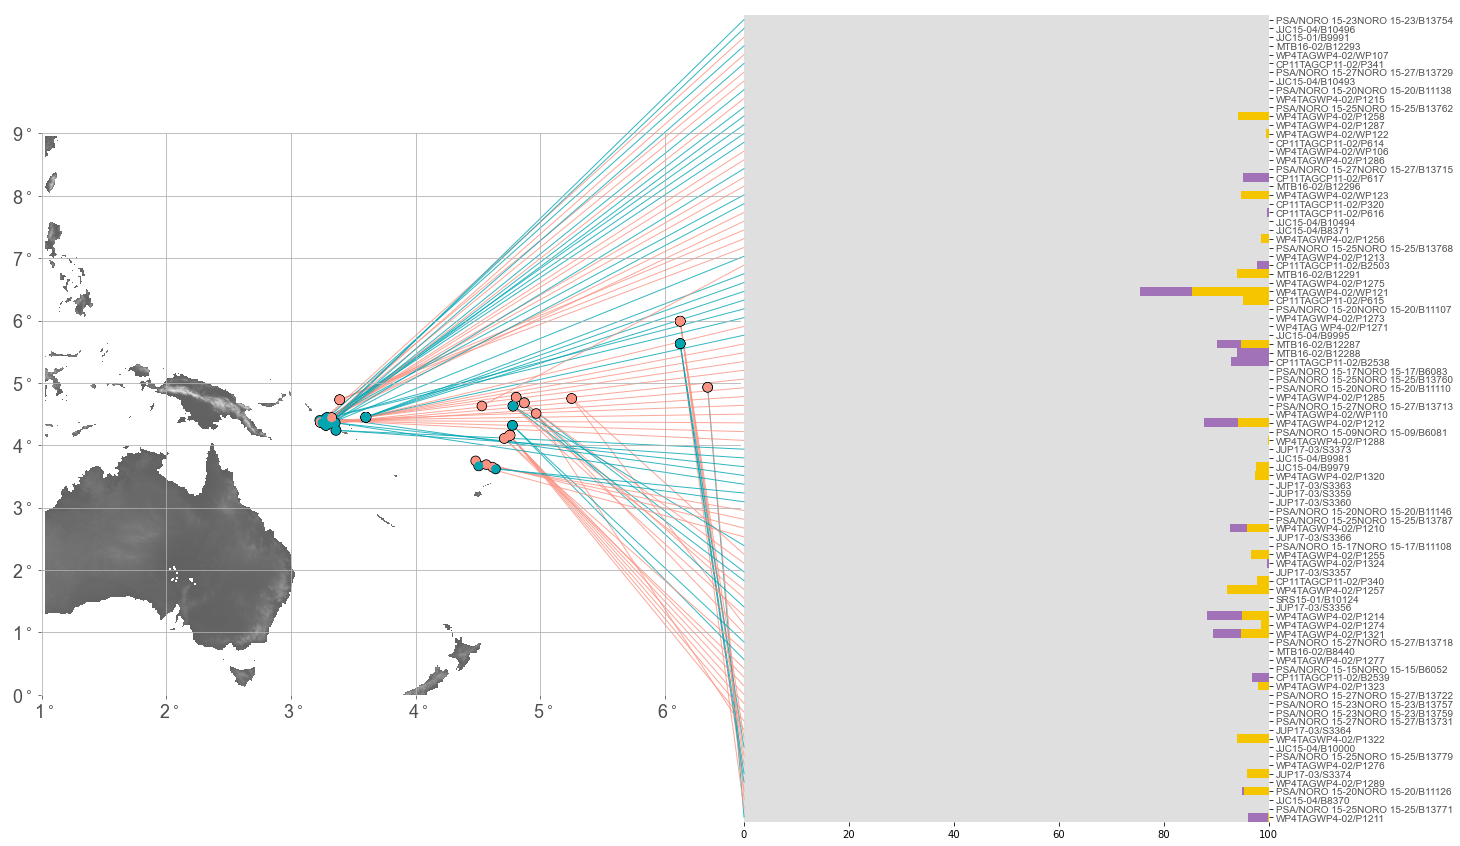

In [26]:
diet_col={'fish':fishcmap,'molusk':moluskcmap,'crus':crusmap}
# asigns a list of tuples to create a colormap. Assigns one colour to each value. More than two are possible if desired.
clist=[(0.0,'#616161'),
       (1.0,'#ffffff')]
# creates the colourmap based on the list above and gives it a name
cmap=mpl.colors.LinearSegmentedColormap.from_list('mapcmap',clist)

# another spp dict
sppdict={'Thunnus albacares':'#00A5B2', 'Katsuwonus pelamis':'#FB9282'}
idsppcolordict=dict(zip(coords['index'],coords['scientific_name'].map(sppdict)))

# create labels with sample number
labels = ['%s'%(tuna_labels_dict[key] if key in tuna_labels_dict else 'none') for key in data.keys()]

fig = plt.figure(figsize=(22,15),facecolor='w') 
G = gridspec.GridSpec(1,2,wspace=0.005,hspace=0.0,width_ratios = [0.8,0.6])

ax1=plt.subplot(G[0,1],facecolor='none')
ax1.set_xlim(0,100)
ax1.set_ylim(-0.5,len(tuna_diet_filtered.items())+0.5)

xyAlist = []
yticks=[]
for ypos,(tid,diet) in enumerate(tuna_diet_filtered.items()):
    left=0
    yticks.append(ypos)
    total=sum(sum([x for x in tuna_diet_filtered[tid].values()],[]))
    if total > 0:
        for kind in diet.keys():
            for i,otu in enumerate(diet[kind]):
                width=(otu*100)/total
                height=1
                if (i%2)==0:
                    colnum=0.4
                else:
                    colnum=0.9
                ax1.barh(ypos,width,height,left=left,align='center',facecolor=diet_col[kind](colnum),edgecolor='none',lw=0.5)
                left+=width
    xyA = (ax1.get_xlim()[0],ypos)
    xyAlist.append(xyA)
[ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.yticks(ticks=yticks,labels = labels,fontsize=10,fontname='Arial',color='#4f4f4f')
ax1.yaxis.tick_right()

ax2=plt.subplot(G[0,0],facecolor='none')
# plots the raster using the colourmap above. Normalizes by altitude in the raster
plt.grid()
ax2.imshow(rasterplot, cmap = cmap, norm = mpl.colors.Normalize(vmin=0, vmax=rasterplot.max().max()))
ax2.scatter(coords['longs'],coords['lats'],s=110,zorder=2,facecolor='k',alpha=1,edgecolor='none') # background
ax2.scatter(coords['longs'],coords['lats'],s=78,zorder=3,facecolor=coords['scientific_name'].map(sppdict),alpha=1,edgecolor='none') # background

ax2.set_yticklabels(labels=['%2.f$^\circ$'%(y) for y in range(0,10,1)][::-1],fontname='Arial',fontsize=18)

ax2.set_xticklabels(labels=['%2.f$^\circ$'%(x) for x in range(0,9,1)],fontname='Arial',fontsize=18)
[ax2.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.tick_params(axis='both', which='major', pad=5,labelcolor='#4f4f4f',color='#4f4f4f')

xyBlist = list(zip(coords['longs'],coords['lats']))

# sets limits
ax2.set_ylim(900,0)

for tuna,aa,bb in zip(coords['index'],xyAlist,xyBlist):
#     print(tuna,aa,bb)
    coordsA = 'data'
    coordsB = 'data'
    con = ConnectionPatch(xyA=aa, xyB=bb, coordsA=coordsA, coordsB=coordsB, axesA = ax1, axesB = ax2, arrowstyle = "-", clip_on = False, zorder = 1, alpha = 0.8,
                          color = idsppcolordict[tuna])
    ax2.add_artist(con)
plt.show()

In [27]:
# estimate number of different OTUs per diet per sample
# print(tuna_diet_filtered.keys(),len(tuna_diet_filtered.values()))
tuna_diet_counts = {}
for key,value in tuna_diet_filtered.items():
    string = ''
    for kk,vv in value.items():
        if kk == 'fish' and len(vv) != 0:
            string += 'F:%s '%(len(vv))
        if kk == 'molusk' and len(vv) != 0:
            string += 'M:%s '%(len(vv))
        if kk == 'crus' and len(vv) != 0:
            string += 'C:%s '%(len(vv))
#         print(key,string)
    tuna_diet_counts[key] = string
tuna_diet_counts

{'GMB.20190219-06': 'F:14 M:2 C:1 ',
 'GMB.20190219-21': 'F:3 ',
 'GMB.20190206-10': 'F:3 ',
 'GMB.20190219-24': 'F:9 M:1 C:2 ',
 'GMB.20190207-29': 'F:4 ',
 'GMB.20190131-06': 'F:4 C:1 ',
 'GMB.20190207-13': 'F:9 ',
 'GMB.20190207-06': 'F:7 ',
 'GMB.20190206-03': 'F:2 ',
 'GMB.20190207-19': 'F:11 C:1 ',
 'GMB.20190131-08': 'F:7 ',
 'GMB.20190207-01': 'F:5 ',
 'GMB.20190219-14': 'F:3 ',
 'GMB.20190219-15': 'F:4 ',
 'GMB.20190207-04': 'F:11 ',
 'GMB.20190207-18': 'F:14 C:2 ',
 'GMB.20190206-27': 'F:9 M:1 C:1 ',
 'GMB.20190207-10': 'F:9 ',
 'GMB.20190207-12': 'F:12 ',
 'GMB.20190206-16': 'F:12 ',
 'GMB.20190206-29': 'F:4 ',
 'GMB.20190207-20': 'F:16 M:1 C:2 ',
 'GMB.20190207-15': 'F:21 C:1 ',
 'GMB.20190219-09': 'F:10 M:1 C:7 ',
 'GMB.20190131-04': 'F:4 ',
 'GMB.20190206-07': 'F:4 ',
 'GMB.20190207-26': 'F:8 C:7 ',
 'GMB.20190206-25': 'F:13 C:3 ',
 'GMB.20190131-03': 'F:3 ',
 'GMB.20190207-17': 'F:12 M:2 ',
 'GMB.20190207-28': 'F:13 C:1 ',
 'GMB.20190207-07': 'F:7 ',
 'GMB.20190131-01': 

In [28]:
# confirm data
tuna_diet_filtered['GMB.20190219-06']

{'fish': [769,
  160,
  26716,
  348210,
  58852,
  4996,
  245,
  256450,
  3041,
  1288,
  1054,
  2278,
  589,
  111],
 'molusk': [3221, 24981],
 'crus': [728]}

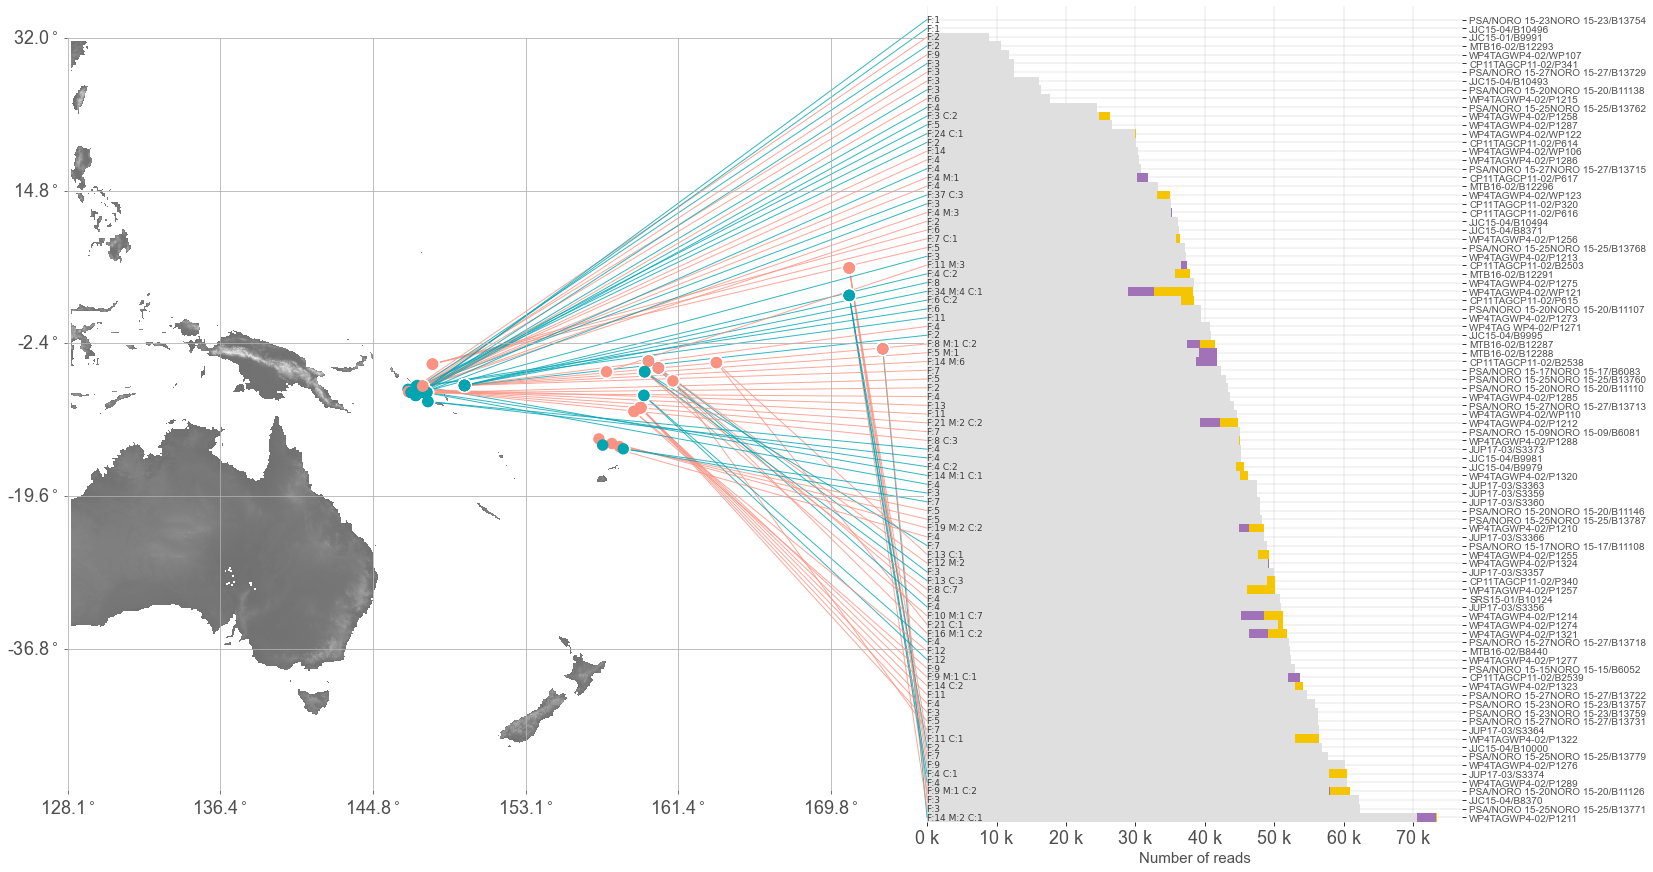

In [29]:
diet_col={'fish':fishcmap,'molusk':moluskcmap,'crus':crusmap}
# asigns a list of tuples to create a colormap. Assigns one colour to each value. More than two are possible if desired.
clist=[(0.0,'#616161'),
       (1.0,'#ffffff')]
# creates the colourmap based on the list above and gives it a name
cmap=mpl.colors.LinearSegmentedColormap.from_list('mapcmap',clist)

# another spp dict
sppdict={'Thunnus albacares':'#00A5B2', 'Katsuwonus pelamis':'#FB9282'}
idsppcolordict=dict(zip(coords['index'],coords['scientific_name'].map(sppdict)))

# create labels with sample number
labels = ['%s'%(tuna_labels_dict[key] if key in tuna_labels_dict else 'none') for key in tuna_diet_filtered.keys()]

fig = plt.figure(figsize=(25,15),facecolor='w') 
G = gridspec.GridSpec(1,2,wspace=0.005,hspace=0.0,width_ratios = [0.8,0.5])

ax1=plt.subplot(G[0,1],facecolor='none')
# ax1.set_xlim(0,100)
ax1.set_ylim(-0.5,len(tuna_diet_filtered.items())+0.5)

xyAlist = []
yticks=[]
for ypos,(tid,diet) in enumerate(tuna_diet_filtered.items()):
    left=0
    yticks.append(ypos)
    total=sum(sum([x for x in tuna_diet_filtered[tid].values()],[]))
    if total > 0:
        for kind in diet.keys():
            for i,otu in enumerate(diet[kind]):
                width=otu
#                 width=(otu*100)/total
                height=1
                if (i%2)==0:
                    colnum=0.4
                else:
                    colnum=0.9
                ax1.barh(ypos,width,height,left=left,align='center',facecolor=diet_col[kind](colnum),edgecolor='none',lw=0.5,zorder=2)
                left+=width
    ax1.text(x = -15, y = ypos, s = tuna_diet_counts[tid], fontsize = 9, color = '#3b3b3b', va = 'center', ha = 'left')

    xyA = (ax1.get_xlim()[0],ypos)
    xyAlist.append(xyA)
[ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.yticks(ticks=yticks,labels = labels,fontsize=10,fontname='Arial',color='#4f4f4f')
plt.xticks(ticks = [x for x in range(0,800000,100000)],labels = ['%s k'%(x) for x in range(0,80,10)],fontsize=18,fontname='Arial',color='#4f4f4f')
plt.xlabel('Number of reads', fontsize=15,fontname='Arial',color='#4f4f4f')
plt.grid(axis='both',zorder=1, lw=0.3)
ax1.yaxis.tick_right()

# ---------------------------------------------------------------------------------------------
ax2=plt.subplot(G[0,0],facecolor='none')
# plots the raster using the colourmap above. Normalizes by altitude in the raster
plt.grid()
ax2.imshow(rasterplot, cmap = cmap, norm = mpl.colors.Normalize(vmin=0, vmax=rasterplot.max().max()), alpha = 0.9)
ax2.scatter(coords['longs'],coords['lats'],s=220,zorder=2,facecolor='w',alpha=1,edgecolor='none') # background
ax2.scatter(coords['longs'],coords['lats'],s=130,zorder=3,facecolor=coords['scientific_name'].map(sppdict),alpha=1,edgecolor='none') # background
# for x,y in zip(coords['longs'],coords['lats']):
#     ax2.text(x,y,s = '%.2f %.2f'%(x,y))

# yyticks=np.linspace(-63.77,11.34,10)
# print(yyticks)
# xxticks=np.linspace(119.7,178.05,8)
# xxticksplot=(xxticks-xmin)//cellsize
# yyticksplot=(nrows-(yyticks-ymin)//cellsize)
# ax2.scatter([0]*len(yyticksplot),yyticksplot,s=70,color='b')
# ax2.scatter(xxticksplot,[0]*len(xxticksplot),s=70,color='g')

ax2.set_yticklabels(labels=['%2.1f$^\circ$'%(y) for y in np.linspace(-36.8, -36.8 + (17.2 * 5),6)][::-1], fontname='Arial', fontsize=18, va = 'center', ha = 'right') # every 8.3
ax2.tick_params(axis='y', which='major', pad=2)
ax2.tick_params(axis='x', which='major', pad=4)
ax2.set_xticklabels(labels=['%2.1f$^\circ$'%(x) for x in np.linspace(119.7,186.5,9)],fontname='Arial',fontsize=18, va = 'top', ha = 'center')
[ax2.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.tick_params(axis='both', which='major', pad=5,labelcolor='#4f4f4f',color='#4f4f4f')

xyBlist = list(zip(coords['longs'],coords['lats']))

# sets limits
# ax2.set_ylim(900,0)

for tuna,aa,bb in zip(coords['index'],xyAlist,xyBlist):
#     print(tuna,aa,bb)
    coordsA = 'data'
    coordsB = 'data'
    con = ConnectionPatch(xyA=aa, xyB=bb, coordsA=coordsA, coordsB=coordsB, axesA = ax1, axesB = ax2, arrowstyle = "-", clip_on = False, zorder = 1, alpha = 0.8,
                          color = idsppcolordict[tuna])
    ax2.add_artist(con)
# plt.savefig('./tuna_20210422temp.svg', bpi = 300)
plt.show()

In [147]:
cursorder=crus_diet.describe().loc['max'].index
moluskorder=molusk_diet.describe().loc['max'].index
crusorder=fish_diet.describe().loc['max'].index